In [ ]:
import arviz as az
import numpy as np
import pymc as pm
from loguru import logger
from matplotlib import pyplot as plt

In [4]:
def plot_priors_and_posteriors(
    trace: az.InferenceData,
    prior_trace: az.InferenceData,
    posterior_trace: az.InferenceData,
):
    _, axes = plt.subplots(3, 2, figsize=(12, 9))

    axes[0][0].hist(prior_trace.prior["p"].mean("chain"))
    axes[0][1].hist(trace.posterior["p"].mean("chain"))

    axes[0][0].set_title("Prior distribution of $p$")
    axes[0][1].set_title("Posterior distribution of $p$")

    axes[1][0].hist(prior_trace.prior["male : female"].mean("chain"))
    axes[1][1].hist(trace.posterior["male : female"].mean("chain"))

    axes[1][0].set_title(r"Prior distribution of $\phi$")
    axes[1][1].set_title(r"Posterior distribution of $\phi$")

    axes[2][0].hist(prior_trace.prior_predictive["likelihood"].mean("chain"))
    axes[2][1].hist(posterior_trace.posterior_predictive["likelihood"].mean("chain"))

    axes[2][0].set_title("Prior distribution of $y$")
    axes[2][1].set_title("Posterior distribution of $y$")

    plt.tight_layout()
    plt.show()

## Goal

- in Germany, there were 980 placenta previa births, 437 of which were female.
- How much evidence does this provide for the claim that the proportion of female births in placenta previa births is less than 0.485 (the proportion of female births in the general population)?

In [ ]:
total_births = 980
total_females = 437

print(f"Empirical proportion = {100.0 * total_females / total_births:.3f}%")

Empirical proportion = 44.592%


In [3]:
with pm.Model() as model1:
    # prior
    p = pm.Uniform(name="p", lower=0, upper=1)

    phi = pm.Deterministic("male : female", (1 - p) / p)

    # likelihood
    likelihood = pm.Binomial(
        name="likelihood",
        n=total_births,
        p=p,
        observed=total_females,
    )

    # sample from posterior
    trace1 = pm.sample(2000, tune=1000, progressbar=True)
    logger.info("Finished sampling!")

    prior_trace1 = pm.sample_prior_predictive(1000)
    logger.info("Finished the prior predictive sampling!")

    posterior_trace1 = pm.sample_posterior_predictive(trace=trace1)
    logger.info("Finished the posterior predictive sampling!")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
2025-05-10 21:09:35.935 | INFO     | __main__:<module>:17 - Finished sampling!
Sampling: [likelihood, p]
2025-05-10 21:09:35.973 | INFO     | __main__:<module>:20 - Finished the prior predictive sampling!
Sampling: [likelihood]


Output()

2025-05-10 21:09:36.225 | INFO     | __main__:<module>:23 - Finished the posterior predictive sampling!


In [5]:
az.summary(trace1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.446,0.016,0.415,0.475,0.000,0.000,3335.0,5149.0,1.0
male : female,1.246,0.081,1.097,1.398,0.001,0.001,3335.0,5149.0,1.0


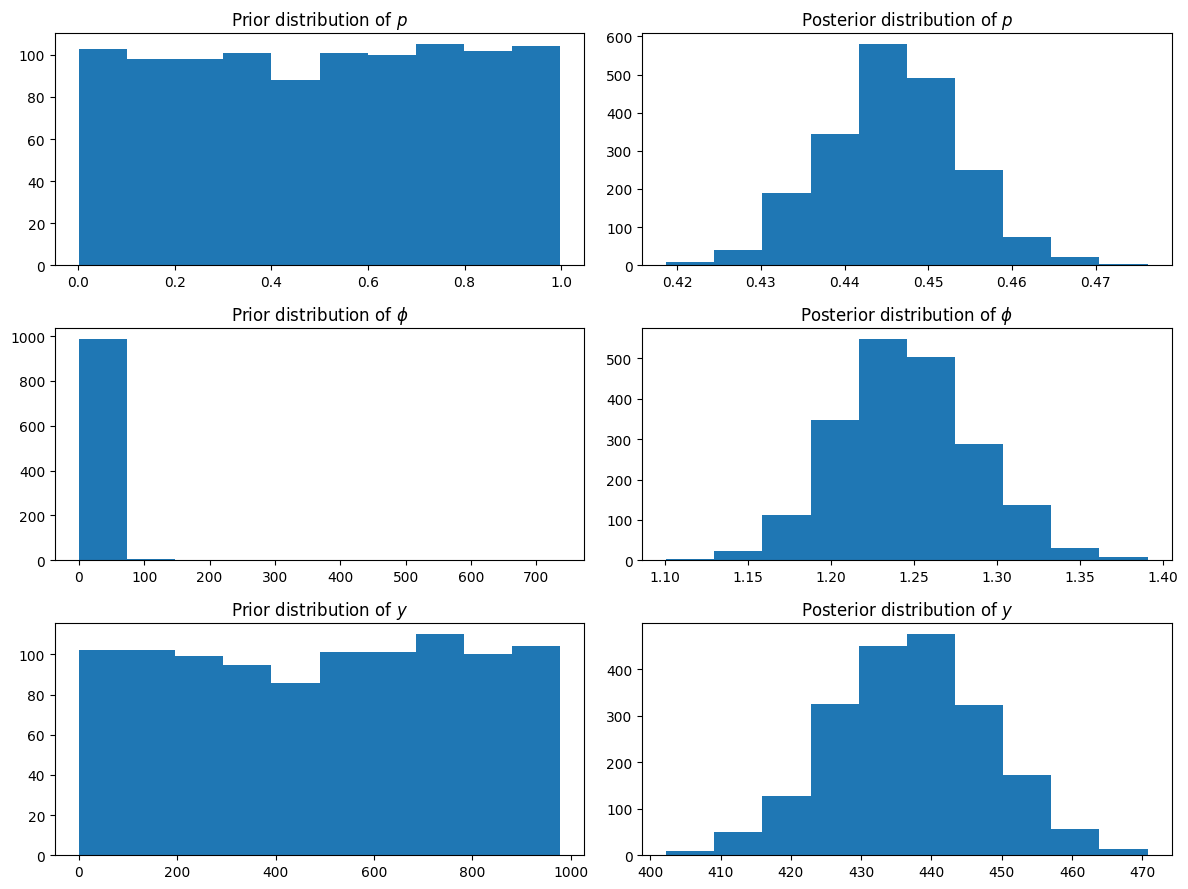

In [ ]:
plot_priors_and_posteriors(
    trace=trace1,
    prior_trace=prior_trace1,
    posterior_trace=posterior_trace1,
)

In [18]:
def calculate_alpha_beta(u: float, v: float) -> tuple[float, float]:
    a = u * v
    b = (1 - u) * v
    return a, b

In [ ]:
from itertools import product

post_means = []
alphas = []
betas = []
us = np.logspace(-3, 0, 10)
vs = np.linspace(2, 100, 10)

for u, v in product(us, vs):
    try:
        alpha, beta = calculate_alpha_beta(u=u, v=v)

        with pm.Model() as m:
            # prior
            p = pm.Beta("p", alpha=alpha, beta=beta)
            phi = pm.Deterministic("male : female", (1 - p) / p)

            # likelihood
            likelihood = pm.Binomial(
                name="likelihood",
                n=total_births,
                p=p,
                observed=total_females,
            )

            # sample from posterior
            trace = pm.sample(1000, tune=1000, progressbar=False)
            posterior_p = trace.posterior["p"].mean("chain")

            post_means.append(np.mean(posterior_p))
            alphas.append(alpha)
            betas.append(beta)
    except Exception as e:
        logger.error(e)
        continue

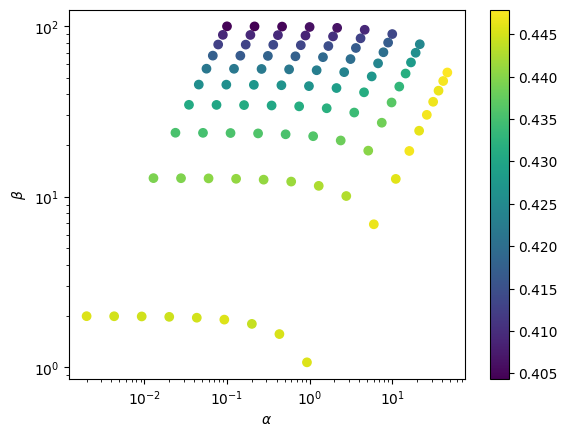

In [90]:
_, ax = plt.subplots()

scatter = ax.scatter(alphas, betas, c=post_means)
ax.set_xscale("log")
ax.set_yscale("log")

plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.colorbar(scatter, ax=ax)
plt.show()